In [137]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [139]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [142]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [144]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [146]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [148]:
# View all of the classes that automap found

for class_name in Base.classes.keys():
    print(class_name)

station
measurement


In [150]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [152]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func
from sqlalchemy.orm import Session
from datetime import datetime, timedelta

In [156]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

if most_recent_date:
    print("Most recent date in the dataset:", most_recent_date[0])

Most recent date in the dataset: 2017-08-23


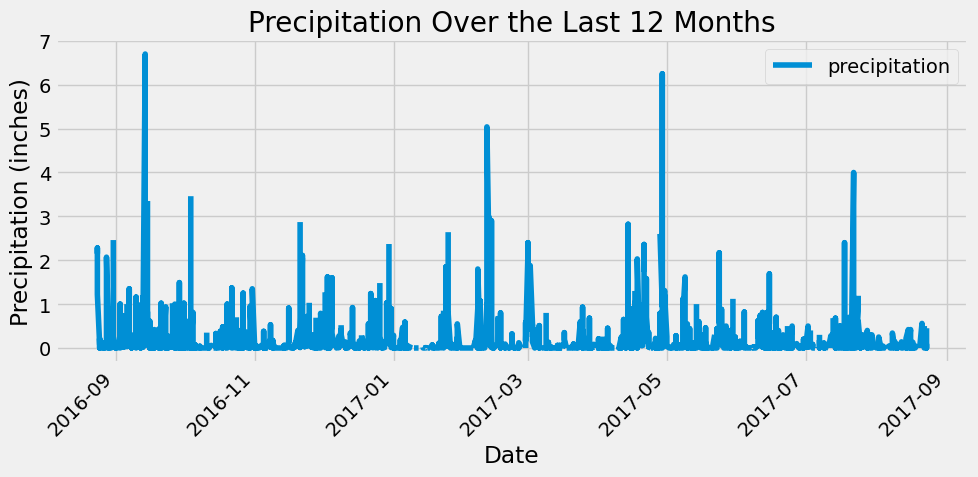

In [158]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)
one_year_ago
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10, 5), title='Precipitation Over the Last 12 Months', ylabel='Precipitation (inches)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [160]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [175]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()
total_stations

9

In [183]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Station.id, Station.name, func.count(Measurement.id).label('count'))
    .join(Station, Station.id == Measurement.station)  # Adjust the join condition based on actual column name
    .group_by(Station.id, Station.name)
    .order_by(func.count(Measurement.id).desc())
    .all()
)

# Print the results
active_stations

[]

In [181]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'  # Example station ID; replace with your actual ID

# Query to find the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# Extract the results
min_temp, max_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp:.2f}") 

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


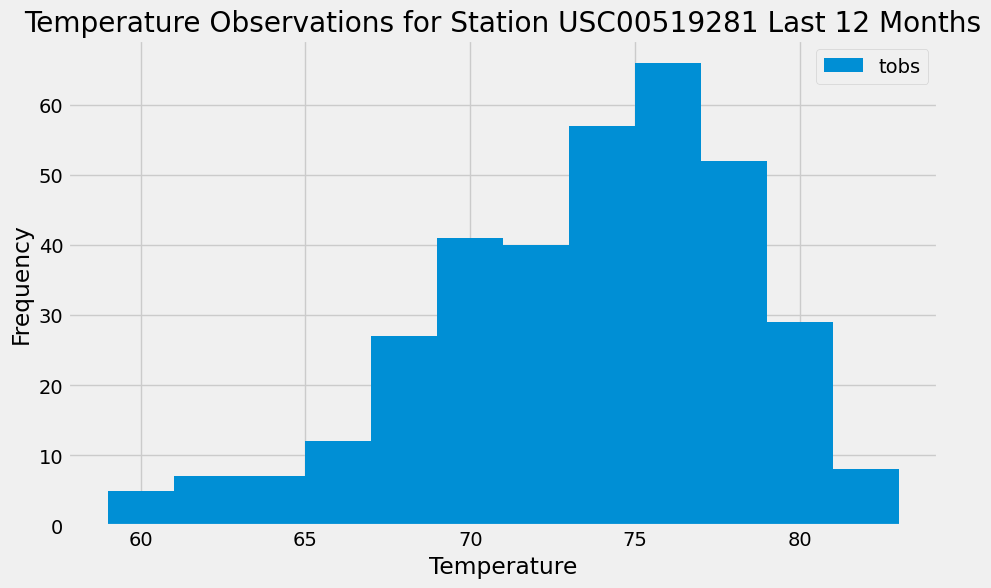

In [191]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active_station_id).\
                    filter(Measurement.date >= one_year_ago).\
                    all()

temperatures = [temp[0] for temp in temperature_data]  # Unpack from the list of tuples

plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id} Last 12 Months')
plt.legend()
plt.show()

# Close Session

In [189]:
# Close Session
session.close()